In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

IMG_SIZE = 40, 40
BATCH_SIZE = 32
SEED = 5
AUTO = tf.data.AUTOTUNE

## Train , val, test 데이터셋 생성

In [3]:
import os
import cv2
import numpy as np

# 이미지 파일을 순수하게 불러오는 함수
def load_data_from_directory(data_directory):
    images = []  # 이미지 데이터를 저장할 리스트
    labels = []  # 레이블 데이터를 저장할 리스트
    desired_size = (224, 224)  # 조정할 이미지 크기 설정

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                img = cv2.imread(image_path)  # 이미지 파일 읽기
                if img is not None:
                    img = cv2.resize(img, desired_size)  # 이미지 크기 조정
                    images.append(img)  # 이미지 리스트에 추가
                    labels.append(class_name)  # 레이블 리스트에 클래스 이름 추가

    images = np.array(images, dtype='float32')  # 이미지 데이터를 NumPy 배열로 변환하고 타입을 float32로 설정

    return images, labels


from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩을 위한 준비
label_encoder = LabelEncoder()

# 데이터 로드
train_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train'
train_images, train_labels = load_data_from_directory(train_data_directory)
train_labels_encoded = label_encoder.fit_transform(train_labels)

test_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/test'
test_images, test_labels = load_data_from_directory(test_data_directory)
test_labels_encoded = label_encoder.transform(test_labels)

valid_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid'
valid_images, valid_labels = load_data_from_directory(valid_data_directory)
valid_labels_encoded = label_encoder.transform(valid_labels)

# 데이터셋 확인
print("훈련 데이터셋 크기:", len(train_images))
print("테스트 데이터셋 크기:", len(test_images))
print("검증 데이터셋 크기:", len(valid_images))

훈련 데이터셋 크기: 900
테스트 데이터셋 크기: 40
검증 데이터셋 크기: 39


In [47]:
# 훈련 데이터셋 변수 확인
print("훈련 데이터셋(train_images) 형태:", train_images.shape)
print("훈련 레이블(train_labels_encoded) 형태:", train_labels_encoded.shape)

# 테스트 데이터셋 변수 확인
print("테스트 데이터셋(test_images) 형태:", test_images.shape)
print("테스트 레이블(test_labels_encoded) 형태:", test_labels_encoded.shape)

# 검증 데이터셋 변수 확인
print("검증 데이터셋(valid_images) 형태:", valid_images.shape)
print("검증 레이블(valid_labels_encoded) 형태:", valid_labels_encoded.shape)

# # train_labels_encoded 변수 확인
# print("훈련 레이블(train_labels_encoded) 형태:", train_labels_encoded.shape)
# print("훈련 레이블(train_labels_encoded) 내용:", train_labels_encoded)

# # test_labels_encoded 변수 확인
# print("테스트 레이블(test_labels_encoded) 형태:", test_labels_encoded.shape)
# print("테스트 레이블(test_labels_encoded) 내용:", test_labels_encoded)

# # valid_labels_encoded 변수 확인
# print("검증 레이블(valid_labels_encoded) 형태:", valid_labels_encoded.shape)
# print("검증 레이블(valid_labels_encoded) 내용:", valid_labels_encoded)

훈련 데이터셋(train_images) 형태: (900, 224, 224, 3)
훈련 레이블(train_labels_encoded) 형태: (900,)
테스트 데이터셋(test_images) 형태: (40, 224, 224, 3)
테스트 레이블(test_labels_encoded) 형태: (40,)
검증 데이터셋(valid_images) 형태: (39, 224, 224, 3)
검증 레이블(valid_labels_encoded) 형태: (39,)


## Custom ConvMixer Layer 사용

In [48]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

## Model

In [49]:
from tensorflow_addons.optimizers import AdamW

# Import necessary libraries
FEATURES = 256
inp = Input(shape=(*IMG_SIZE, 3))  # Define the input shape

X = Conv2D(FEATURES, 2, 2)(inp)  # Apply 2D convolutional layer
X = Activation('gelu')(X)  # Apply GELU activation function
X = BatchNormalization()(X)  # Apply Batch Normalization

# Apply ConvMixerBlocks
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_8')(X)

X = GlobalAveragePooling2D()(X)  # Apply Global Average Pooling
out = Dense(6, activation='softmax')(X)  # Output layer with softmax activation

model = Model(inputs=inp, outputs=out)  # Create the model
model.summary()  # Display model summary

import tensorflow_addons as tfa

model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 256)       3328      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 20, 256)       0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 20, 20, 256)       1024      
_________________________________________________________________
CONVMIXER_1 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_2 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_3 (ConvMixerBlock) (None, 20, 20, 256)       7449

### 데이터 파이프라인 구축

In [52]:
# Reading -> Resizing -> Normalization
# 이미지 전처리 함수
def img_preprocessing(image, label):
    img = tf.image.resize(image, size=IMG_SIZE)  # IMG_SIZE 사용
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# 데이터 증강 함수
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    return img, label

In [53]:
import pandas as pd

# train_images와 train_labels_encoded를 결합하여 데이터 프레임 생성
train_df = pd.DataFrame({
    'img': list(train_images),
    'label': train_labels_encoded
})

# 데이터 프레임 형태 확인
print("Train DataFrame shape:", train_df.shape)

Train DataFrame shape: (900, 2)


## 10 Folds Training

In [54]:
# 빈 리스트들을 생성하여 fold_hists, test_evals, test_preds에 데이터 저장할 공간을 마련합니다.
fold_hists = []
test_evals = []
test_preds = []

# 학습에 사용할 에포크와 K-Fold 교차 검증 횟수를 설정합니다.
EPOCHS = 20
FOLDS = 10

# K-Fold 교차 검증을 위한 KFold 객체를 생성합니다.
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# K-Fold 교차 검증 루프를 시작합니다.
for i, (train_index, val_index) in enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*90)
    print(str(i+1) + '. 폴드 학습 진행 중')
    
    # 데이터를 수정하여 훈련 및 검증 데이터로 나눕니다.
    X_train_fold_images = np.stack(train_df['img'].iloc[train_index].values)
    y_train_fold_labels = train_df['label'].iloc[train_index].values
    
    # kfold에 포함되지 않는 학습데이터를 활용해 검증데이터를 생성합니다.
    X_val_fold_images = np.stack(train_df['img'].iloc[val_index].values)
    y_val_fold_labels = train_df['label'].iloc[val_index].values

    # TensorFlow 데이터 파이프라인을 생성합니다.
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold_images, y_train_fold_labels))  # 데이터 슬라이스로부터 훈련 데이터셋을 생성합니다.
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls=AUTO)  # 이미지 전처리 함수를 매핑하여 데이터 변환합니다.
                     .map(augmentation, num_parallel_calls=AUTO)  # 데이터 증강 함수를 매핑하여 데이터 변환합니다.
                     .batch(BATCH_SIZE)  # 배치 크기를 설정합니다.
                     .shuffle(BATCH_SIZE * 5)  # 데이터를 섞습니다.
                     .prefetch(AUTO))  # 데이터 사전 로드를 설정합니다.

    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold_images, y_val_fold_labels))  # 데이터 슬라이스로부터 검증 데이터셋을 생성합니다.
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls=AUTO)  # 이미지 전처리 함수를 매핑하여 데이터 변환합니다.
                          .batch(BATCH_SIZE)  # 배치 크기를 설정합니다.
                          .prefetch(AUTO))  # 데이터 사전 로드를 설정합니다.


    # 모델 훈련을 진행합니다.
    hist = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_dataset, verbose=0)
    fold_hists.append(hist)

    # 테스트 데이터 평가를 진행합니다.
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('테스트 손실: {0:.3f}'.format(test_eval[0]))
    print('테스트 정확도: {0:.3f} %'.format(test_eval[1] * 100))
    print('테스트 상위 2 정확도: {0:.2f} %'.format(test_eval[2] * 100))

    # 테스트 데이터 예측을 진행합니다.
    test_take1 = test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training
2/2 [==============================] - 0s 53ms/step - loss: 1.9249 - acc: 0.1750 - top_3_acc: 0.4500
Test Loss: 1.925
Test Accuracy: 17.500 %
Test Sparse Top 2 Accuracy: 45.00 %
------------------------------------------------------------------------------------------
2.fold training
2/2 [==============================] - 0s 9ms/step - loss: 1.6914 - acc: 0.3000 - top_3_acc: 0.6250
Test Loss: 1.691
Test Accuracy: 30.000 %
Test Sparse Top 2 Accuracy: 62.50 %
------------------------------------------------------------------------------------------
3.fold training
2/2 [==============================] - 0s 9ms/step - loss: 1.6644 - acc: 0.3250 - top_3_acc: 0.6500
Test Loss: 1.664
Test Accuracy: 32.500 %
Test Sparse Top 2 Accuracy: 65.00 %
------------------------------------------------------------------------------------------
4.fold training
2/2 [==============================] - 0

## 학습 결과

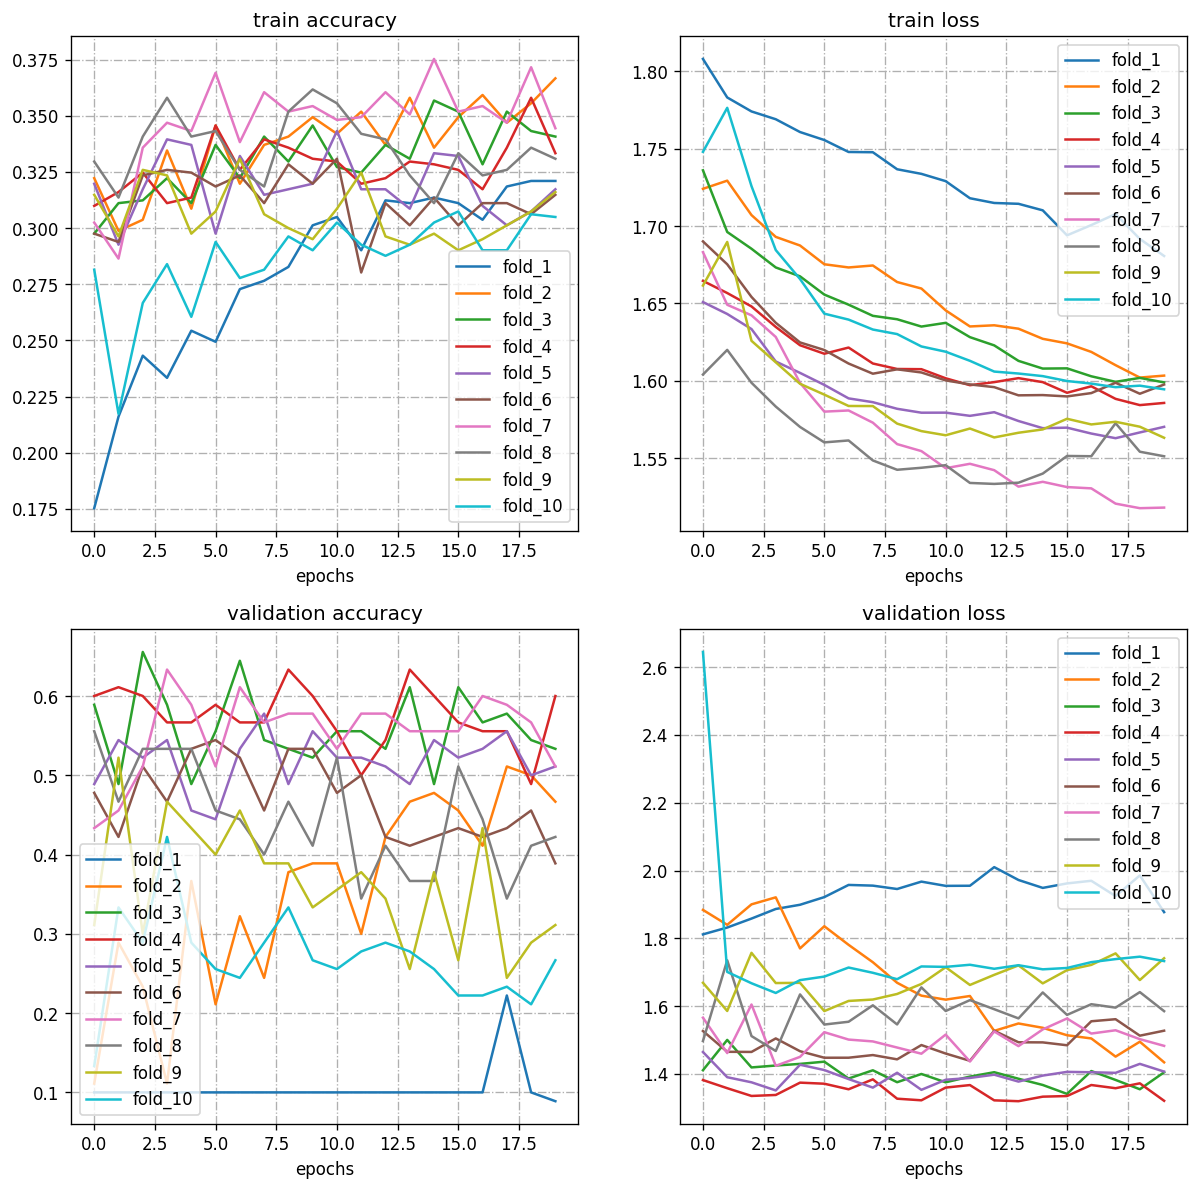

In [55]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)


## Ensemble Test Prediction

In [56]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

In [60]:
len(test_df['label'])

135

In [58]:
len(preds)

40

In [59]:
len(last_pred)

40

## Test Classifiation Report

In [57]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(jellyfish_classes.values()))
print(clf)

ValueError: Found input variables with inconsistent numbers of samples: [135, 40]

## Test Confusion Matrix

In [ ]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(jellyfish_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

## Test Predictions

In [ ]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
    
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'red')

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 145)
random_test_sample_with_prediction(SEED = 7)
random_test_sample_with_prediction(SEED = 78)
random_test_sample_with_prediction(SEED = 98)